<div style='width: 750px; margin-left: 30px;'><h3>A quick introduction, and playground for Multi-armed Bandit Problems/Algorithms</h3>
<br />
<div style='font-size:16px; font-family:Sans-Serif;'>

<h4>Base case</h4>
<ul style='margin-left:30px'>
<li>There is a set $\mathcal{A}$ of m actions (or arms) that is available to the agent.</li>
<li>Each action $a$ is associated with a reward distribution $\mathcal{R}^a$. </li>
<li>At each timestep $t$, the agent chooses an action $a_t \in \mathcal{A}$ and receives a reward $r_t \sim \mathcal{R}^{a_t}$.</li>
<li>The agent's goal is to maximize total reward: $ \sum_{t=1}^T r_t$.</li>
</ul> <br />
The last statement is equivalent to minimizing regret, where we define regret as the difference between the reward asscoaited with the best possible action at step $t$, and the reward that was actually received: $l_t=\max\limits_{a_t \in \mathcal{A}}\mathbf{E}[r_t|a_t]-r_t$
<p></p>
</div>
</div>

In [765]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

<h4>Four normals with different expected/variance.</h4> <br />
$
\begin{align}
\mathcal{R_1} &\sim \mathcal{N}(15, 10)\\
\mathcal{R_1} &\sim \mathcal{N}(5, 25)\\
\mathcal{R_1} &\sim \mathcal{N}(15, 25)\\
\mathcal{R_1} &\sim \mathcal{N}(30, 20)
\end{align}
$

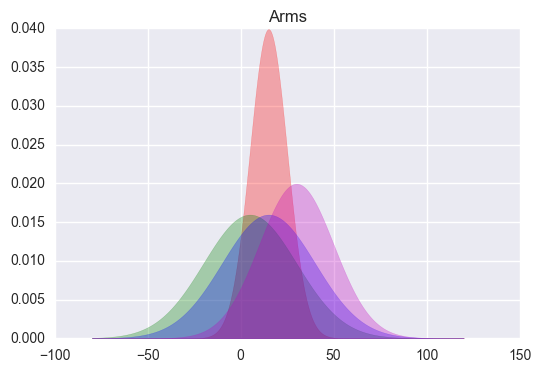

In [776]:
params = [(15, 10), (5, 25), (15, 25), (30, 20)]
arms = [BaseArm(norm(u, s)) for u, s in params]
env = Environment(arms)

x = np.linspace(-80, 120, 1000)
for (mu, s), c in zip(params, ['r', 'g', 'b', 'm']):
    plt.fill_between(x, norm.pdf(x, mu, s), alpha=0.3, color=c)
plt.title("Arms")
plt.show()

In [777]:
def plot_agents(data):
    fig = plt.figure(figsize=(10, 8))
    rewards_ax = fig.add_subplot(211)
    choices_ax = fig.add_subplot(212)
    max_choice = 0
    for agent_name, (choices, rewards) in data.items():
        max_choice = np.max(np.array([np.max(choices), max_choice]))
        diffs = np.matmul(rewards, np.array([[1, -1]]).transpose()).cumsum()
        label = label='Agent: {}'.format(agent_name)
        rewards_ax.plot(xrange(diffs.shape[0]), diffs, label=label, alpha=0.7)
        rewards_ax.set_title("Rewards")
        choices_ax.plot(xrange(choices.shape[0]), choices, label=label, alpha=0.7)
        choices_ax.set_title("Choices")
    rewards_ax.set_xlabel("Timestep")
    rewards_ax.set_ylabel("Cumulative reward")
    choices_ax.set_ylim([0, max_choice+5])
    choices_ax.set_xlabel("Timestep")
    choices_ax.set_ylabel("Action taken")
    rewards_ax.legend(bbox_to_anchor=(1.2, 0.1))
    fig.tight_layout()
    plt.show()

In [778]:
import numpy as np
import random

class Environment(object):    
    
    def __init__(self, arms):
        self.arms = arms
        
    def m(self):
        return len(self.arms)
        
    def pull(self, i, *ctx):
        r = self.arms[i].pull(*ctx)
        return max(a.expected(*ctx) for a in arms), r

class Arm(object):
    
    def pull(self, *ctx):
        raise NotImplementedError

    def expected(self):
        raise NotImplementedError

class BaseArm(Arm):
    
    def __init__(self, D):
        self.D = D
    
    def pull(self):
        return self.D.rvs()
    
    def expected(self):
        return self.D.mean()
    
class Agent(object):
    
    def play(self, T):
        raise NotImplementedError

class RandomAgent(Agent):
    
    def __init__(self, env):
        self.env = env

    def play(self, T):
        m = self.env.m()
        choices = np.random.randint(0, high=m, size=T)
        opt_rewards = np.array([self.env.pull(i) for i in choices])
        return choices, opt_rewards
    
class EpsilonGreedyAgent(Agent):
    
    def __init__(self, env, e):
        self.env = env
        self.e = e
    
    def play(self, T):
        Q = np.zeros(self.env.m())
        N = np.zeros(self.env.m())
        choices = np.zeros(T)
        opt_rewards = np.zeros((T, 2))
        for t in xrange(T):
            i = np.random.randint(0, high=self.env.m()) if self.e > np.random.rand() else np.argmax(Q)
            opt, reward = self.env.pull(i)
            N[i] += 1
            Q[i] += (reward-Q[i]) / N[i]
            choices[t] = i
            opt_rewards[t, ]  = np.array([opt, reward])
        return choices, opt_rewards

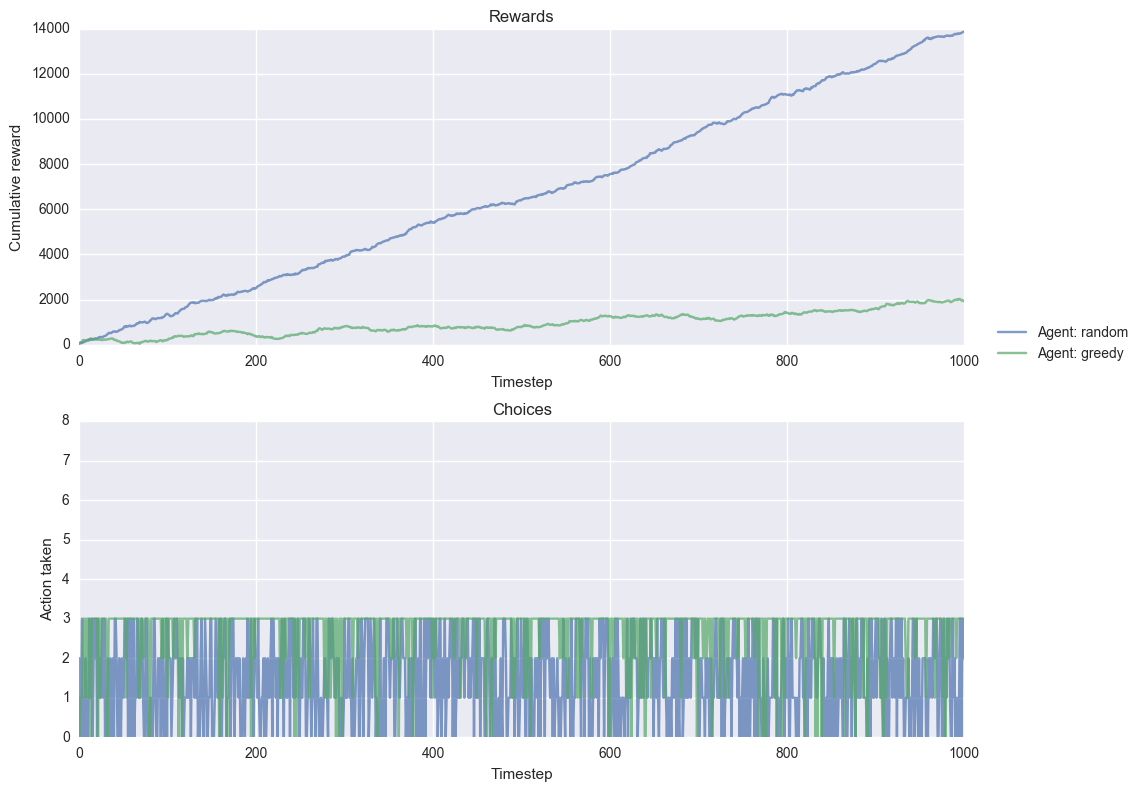

In [779]:

random_agent = RandomAgent(env)
greedy_agent = EpsilonGreedyAgent(env, 0.2)

random_choices, random_opt_rewards = random_agent.play(1000)
greedy_choices, greedy_opt_rewards = greedy_agent.play(1000)
plot_agents({"random": (random_choices, random_opt_rewards),
             "greedy": (greedy_choices, greedy_opt_rewards)})